In [22]:
import os 

# Linux
# !g++ -o stats_multithread.exe main.cpp kernels.cpp -I/c/Users/Administrator/Desktop/projects_job_seek/physnum_CUDA/MonteCarlo/boost_1_89_0/ -I/./
# !./test.exe 1000000 2 1000 4

# Windows
!g++ -o stats_multithread.exe main.cpp kernels.cpp -IC:\Users\Administrator\Desktop\projects_job_seek\physnum_CUDA\MonteCarlo\boost_1_89_0 -I.

!stats_multithread.exe



using a total of 2 threads for par vect input and par vect treat 
 
parallel vectors input - parallel vector treatment: 0.0049809 [s]
 
parallel vectors input - serial vector treatment: 0.000495 [s]
 
serial vectors input - parallel vector treatment: 0.0016769 [s]
 
serial vectors input - serial vector treatment: 0.000409 [s]
 
comparison between serial and single layer parallelism: 
max_abs_diff_1: 0
max_abs_diff_2: 0
comparison between serial and nested parallelism: 
max_abs_diff_1: 0
max_abs_diff_2: 0
Max correlation difference between serial and parallel: 0
max correlation is: 0.0607919


In [42]:
import pandas as pd
import numpy as np
import subprocess

df_tot = None

for jj in range(5):
    N_tot = 10**2 * 2**jj
    subprocess.run([r".\stats_multithread.exe", str(N_tot)], check=True)

    df = pd.read_csv("timing.csv", sep=";")  
    df = df.rename(columns={"time": "N="+str(N_tot)}) 
    if df_tot is None:
        df_tot = df.copy()
    else:
        df_tot = df_tot.merge(df, on="method", how="outer")

df_tot.head()





,method,N=100,N=200,N=400,N=800,N=1600
0,parallel vectors input - parallel vector treat...,0.000705,0.000582,0.001140,0.000756,0.000886
1,parallel vectors input - serial vector treatment:,0.000304,0.000399,0.000400,0.000222,0.000288
2,serial vectors input - parallel vector treatment:,0.000964,0.000833,0.001256,0.000761,0.000853
3,serial vectors input - serial vector treatment:,0.000014,0.000021,0.000045,0.000061,0.000112


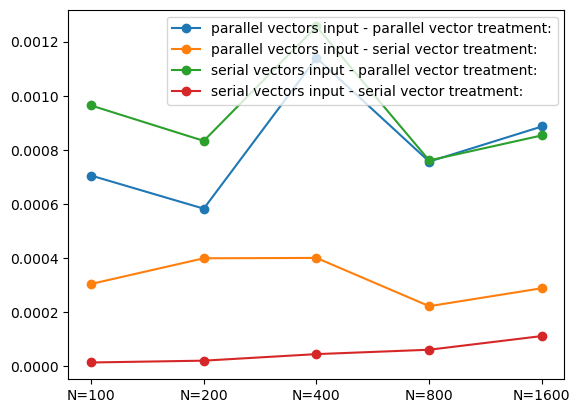

In [43]:
num_cols = df_tot.columns.drop("method")

for ii in range(df_tot.shape[0]):
    y = df_tot.loc[ii, num_cols].values
    plt.plot(num_cols, y, marker="o", label=df_tot.loc[ii, "method"])
plt.legend()